# ICON-ERA5 Circulation Regimes

# Import packages

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.path as mpath
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import scipy
import datetime
import cartopy
from metpy.units import units
import cartopy.crs as ccrs
import pickle
import os
import glob
import subprocess
import dask
from joblib import Parallel, delayed
from geopy.distance import distance  
from collections import defaultdict

import concurrent.futures


### Load MOAAP functions
import sys
sys.path.append('/work/aa0049/a271122/MOAAP/MOAAP/')
from src.utils import *
from src.Corrections import * 
from src.Enumerations import Month, Season, Experiments, Domains
from src.xarray_util import create_obj_from_dict,  ObjectContainer,  load_tracking_objects
from src.plot_funcs import plot_contourf_rotated_grid #, plot_unstructured_rotated_grid

from src.GridPoints import Domain

### Load my functions
from ICON_utils import *
from ICON_circulation import *

/work/aa0049/a271122/MOAAP/MOAAP/src/xarray_util.py:28: AccessorRegistrationWarning: registration of accessor <class 'src.xarray_util.Accessor'> under name 'get' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  class Accessor:


In [2]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [ ]:
arctic_cluster_path = '/work/aa0049/a271122/ERA5/CirculationRegime_clusters/'

# Load Objects

In [3]:
# Extract the rotated coordinate system from example file
ds=xr.open_dataset('/work/aa0049/a271041/spice-v2.1/chain/work/run_era5_polarres_wp3_hindcast2/post/yearly/T_2M/T_2M_2020010100-2020123123.ncz')

crs_rot = ccrs.RotatedPole(pole_longitude=ds.rotated_pole.attrs['grid_north_pole_longitude'],\
                           pole_latitude=ds.rotated_pole.attrs['grid_north_pole_latitude'])

In [11]:
#Control
with open('/work/aa0238/a271093/results/MOAAP/IVT_Tracking/NorESM_control_remapped_3x/Object_container_1984-2014_withClusters.pkl', 'rb') as f:
   objs = pickle.load(f) 


In [ ]:
#SSP
with open('/work/aa0049/a271122/MOAAP/IVT_Tracking/NorESM_ssp_remapped_3x/Object_container_ssp_all.pkl', 'rb') as f:
   objs_ssp = pickle.load(f) 

In [ ]:
objs_sel_ssp, ids_sel_ssp = sel_objs(objs_ssp,season='DJF')
#DJF 
objs_sel_tc_ssp = extract_and_transform_rot_coords(objs_sel_ssp)
#DJF
objs_final_ssp = create_final_objs(objs_sel_tc_ssp)

for i in range(len(objs_final_ssp)):
    for t in objs_final_ssp[i].times:
        if t.dt.month == 3:
            print(str(i)+": MARCH")
            break


In [ ]:
objs_final_ssp.pop()
objs_final_ssp.pop()


In [ ]:
#SSP 15-39
with open('/work/aa0049/a271122/MOAAP/IVT_Tracking/NorESM_ssp_remapped_3x/Object_container_2015-2039_withClusters_filtered.pkl', 'rb') as f:
    objs_final_15_39 = pickle.load(f)

In [ ]:
for i in range(len(objs_final_15_39)):
    for t in objs_final_15_39[i].times:
        if t.dt.month == 3:
            print(str(i)+": MARCH")
            break


In [ ]:
#SSP 40-69
with open('/work/aa0049/a271122/MOAAP/IVT_Tracking/NorESM_ssp_remapped_3x/Object_container_2040-2069_withClusters_filtered.pkl', 'rb') as f:
    objs_final_40_69 = pickle.load(f)

In [ ]:
for i in range(len(objs_final_40_69)):
    for t in objs_final_40_69[i].times:
        if t.dt.month == 3:
            print(str(i)+": MARCH")
            break


In [5]:
#SSP 70-99
with open('/work/aa0049/a271122/MOAAP/IVT_Tracking/NorESM_ssp_remapped_3x/Object_container_2070-2099_withClusters_filtered.pkl', 'rb') as f:
    objs_final_70_99 = pickle.load(f)

In [6]:
for i in range(len(objs_final_70_99)):
    for t in objs_final_70_99[i].times:
        if t.dt.month == 3:
            print(str(i)+": MARCH")
            break


12: MARCH


In [ ]:
#objs_final_70_99.pop(12)

# Define custom sectors for selection

In [13]:
from enum import Enum

class Domains(Enum):
    # JLa custom domains
    NORTH_ATLANTIC_JLa = Domain(north=80, south=67, east=60, west=-30)
    BEAUFORT_SIBERIAN_JLa = Domain(north=80, south=70, east=-120, west=120)
    CENTRAL_ARCTIC_JLa = Domain(north=90, south=80, east=180, west=-180)



# Define new domain values
NORTH_ATLANTIC_JLa = Domain(north=80, south=67, east=60, west=-30)
BEAUFORT_SIBERIAN_JLa = Domain(north=80, south=70, east=120, west=-120)
CENTRAL_ARCTIC_JLa = Domain(north=90, south=80, east=180, west=-180)


gridspacing=0.75
lat=np.arange(-90, 90+gridspacing,gridspacing)
lon=np.arange(-180, 180+gridspacing,gridspacing)
ds_dummy = xr.Dataset({"dummy": (("lat", "lon"), np.ones([len(lat), len(lon)]))},coords={"lon": lon,"lat": lat})


dd=ds_dummy.copy()
mask_domain_CentralArctic=dd.dummy.where(dd.lat>80).notnull()
mask_domain_NorthAtlantic=dd.dummy.where((dd.lat<=80) & (dd.lat>67) & (dd.lon>-30) & (dd.lon<60)).notnull()
mask_domain_BeaufortSiberianSea1=dd.dummy.where((dd.lat<=80) & (dd.lat>70) & (dd.lon>120)).notnull()
mask_domain_BeaufortSiberianSea2=dd.dummy.where((dd.lat<=80) & (dd.lat>70) & (dd.lon<-120)).notnull()

mask_domain_BeaufortSiberianSea = mask_domain_BeaufortSiberianSea1 | mask_domain_BeaufortSiberianSea2

mask_domains = {
    "CentralArctic": {"mask": mask_domain_CentralArctic, "color": 'b'},
    "NorthAtlantic": {"mask": mask_domain_NorthAtlantic, "color": 'r'},
    "BeaufortSiberianSea": {"mask": mask_domain_BeaufortSiberianSea, "color": 'g'},
}


# Select Objects with respect to season and/or sector

In [12]:
df_objs=define_df_objs(objs)

In [14]:
#Filter for all DJF trans-Arctic objects
objs_sel, ids_sel = sel_objs(objs,season='DJF')
#DJF 
objs_sel_tc = extract_and_transform_rot_coords(objs_sel)

#DJF
objs_final = create_final_objs(objs_sel_tc)

10


In [16]:
#Check for March
for i in range(len(objs_final)):
    for t in objs_final[i].times:
        if t.dt.month == 3:
            print(str(i)+": MARCH")
            break


4: MARCH


In [17]:
objs_final.pop(4)

<xarray.Dataset>
Dimensions:          (times: 198)
Coordinates:
  * times            (times) datetime64[ns] 1999-02-26T20:00:00 ... 1999-03-0...
Data variables: (12/17)
    id_              <U6 '150538'
    exp              object <class 'src.Experiments_infos.ICON_NorESM_CONTROL'>
    size             (times) float64 1.061e+06 1.119e+06 ... 6.571e+03 3.279e+03
    total_IVT        (times) float32 1.508e+05 1.652e+05 ... 612.0 302.2
    mean_IVT         (times) float32 146.4 151.4 155.1 ... 103.0 102.0 100.7
    max_IVT          (times) float32 245.1 301.0 326.7 ... 106.3 103.8 101.2
    ...               ...
    gridpoints       (times) object [RotatedGridPoint(lat=12.399999618530273,...
    clusters         (times) <U11 'WINTER-SCAN' 'WINTER-SCAN' ... 'SPRING-ATL+'
    lat              (times) float32 21.7 22.3 22.6 22.6 ... -9.2 -9.8 -10.4
    lon              (times) float32 -2.6 -2.6 -2.6 -2.3 ... -0.8 -0.5 0.1 0.4
    geo_lat          (times) float64 74.64 74.05 73.76 ... 74.24 73.65 73.05
    geo_lon          (times) float64 9.158 8.786 8.61 ... 178.2 -179.6 -178.7

## Select time chunks

In [18]:
#Select all dates in which an event appeared 
objs_times=[ds.times for ds in objs_final]

#Combine all dates in a data array 
objs_all_times = xr.concat(objs_times, dim='times').sortby('times').drop_duplicates(dim='times')

#Select all dates in which objects are in specific domains 
NA_combined_times, CA_combined_times, BS_combined_times = combine_times(objs_final)

In [19]:
NA_month_day, CA_month_day, BS_month_day = get_calendar_days(NA_combined_times, CA_combined_times, BS_combined_times)

#### SSP

In [ ]:
#2015-2099
#Select all dates in which an event appeared 
objs_times_ssp=[ds.times for ds in objs_final_ssp]

#Combine all dates in a data array 
objs_all_times_ssp = xr.concat(objs_times_ssp, dim='times').sortby('times').drop_duplicates(dim='times')

#Select all dates in which objects are in specific domains 
NA_combined_times_ssp, CA_combined_times_ssp, BS_combined_times_ssp = combine_times(objs_final_ssp)

# Get calendar days
NA_month_day_ssp, CA_month_day_ssp, BS_month_day_ssp = get_calendar_days(NA_combined_times_ssp, CA_combined_times_ssp, BS_combined_times_ssp)


In [ ]:
df_objs_ssp=define_df_objs(objs_final_70_99)

In [43]:
#2015-2039
#Select all dates in which an event appeared 
objs_times_ssp_39=[ds.times for ds in objs_final_15_39]

#Combine all dates in a data array 
objs_all_times_ssp_39 = xr.concat(objs_times_ssp_39, dim='times').sortby('times').drop_duplicates(dim='times')

#Select all dates in which objects are in specific domains 
NA_combined_times_39, CA_combined_times_39, BS_combined_times_39 = combine_times(objs_final_15_39)

# Get calendar days
NA_month_day_ssp_39, CA_month_day_ssp_39, BS_month_day_ssp_39 = get_calendar_days(NA_combined_times_39, CA_combined_times_39, BS_combined_times_39)

In [44]:
#2040-2069
#Select all dates in which an event appeared 
objs_times_ssp_69=[ds.times for ds in objs_final_40_69]

#Combine all dates in a data array 
objs_all_times_ssp_69 = xr.concat(objs_times_ssp_69, dim='times').sortby('times').drop_duplicates(dim='times')

#Select all dates in which objects are in specific domains 
NA_combined_times_69, CA_combined_times_69, BS_combined_times_69 = combine_times(objs_final_40_69)

#Get calendar days
NA_month_day_ssp_69, CA_month_day_ssp_69, BS_month_day_ssp_69 = get_calendar_days(NA_combined_times_69, CA_combined_times_69, BS_combined_times_69)


In [41]:
#2070-2099
#Select all dates in which an event appeared 
objs_times_ssp_99=[ds.times for ds in objs_final_70_99]

#Combine all dates in a data array 
objs_all_times_ssp_99 = xr.concat(objs_times_ssp_99, dim='times').sortby('times').drop_duplicates(dim='times')

#Select all dates in which objects are in specific domains 
NA_combined_times_99, CA_combined_times_99, BS_combined_times_99 = combine_times(objs_final_70_99)


NA_month_day_ssp_99, CA_month_day_ssp_99, BS_month_day_ssp_99 = get_calendar_days(NA_combined_times_99, CA_combined_times_99, BS_combined_times_99)


# Circulation Regimes

In [23]:
domain_hatch = {
    "NA": "---",   # Diagonal stripes
    "CA": "///",    # Vertical stripes
    "BS": "...",     # No pattern (solid fill)
    "NONE": ""   # Optional: Cross-hatch for no domain
}
domain_color = {"NA": "white", "CA": "white", "BS": "white", "NONE": "white"}


legend_patches = [
    mpatches.Patch(facecolor="lightgray", hatch=domain_hatch["NA"], label="North Atlantic"),
    mpatches.Patch(facecolor="lightgray", hatch=domain_hatch["CA"], label="Central Arctic"),
    mpatches.Patch(facecolor="lightgray", hatch=domain_hatch["BS"], label="Beaufort Sea"),
]

In [24]:
arctic_cluster_path = '/work/aa0049/a271122/ICON_ERA5/CirculationRegime_clusters/'

In [34]:
image_path = '/work/aa0049/a271109/data_misc/CirculationRegime_clusters/regime_images_new/'
image_file_map = {
    'djfm':{'ATL-':'djfm_01_atl-.png','NAO+':'djfm_02_nao+.png','DIPOL':'djfm_03_dipol.png','SCAN':'djfm_04_scan.png','NAO-':'djfm_05_nao-.png' },
    'mamj':{'ATL-':'mamj_01_atl-.png','NAO+':'mamj_02_nao+.png','SCAN':'mamj_03_scan.png','DIPOL':'mamj_04_dipol.png','NAO-':'mamj_05_nao-.png' },
    'jjas':{'SCAN':'jjas_01_scan.png','SNAO+':'jjas_02_snao+.png','ATL-':'jjas_03_atl-.png','SNAO':'jjas_04_snao-.png','DIPOL':'jjas_05_dipol.png' },
    'sond':{'NAO+':'sond_01_nao+.png','ATL':'sond_02_atl.png','SCAN':'sond_03_scan.png','DIPOL':'sond_04_dipol.png','NAO-':'sond_05_nao-.png' } }



In [35]:
#Define regime colors and images in dictionary
regimes = {
    '0': {'color': 'indigo', 'image': f"{image_path}{image_file_map['djfm']['DIPOL']}",'name':'WINTER-DIP'},
    '1': {'color': 'red', 'image': f"{image_path}{image_file_map['djfm']['NAO+']}",'name':'WINTER-NAO+'},
    '2': {'color': 'yellow', 'image': f"{image_path}{image_file_map['djfm']['NAO-']}",'name':'WINTER-NAO-'},
    '3': {'color': 'lightblue', 'image': f"{image_path}{image_file_map['djfm']['SCAN']}",'name':'WINTER-SCAN'},
    '4': {'color': 'grey', 'image': f"{image_path}{image_file_map['djfm']['ATL-']}",'name':'WINTER-ATL-'}
}

## Daily 5 clusters 

In [ ]:
# Daily clusters based on the 700 hPA GPH

In [3]:
df_NorESM_control =  xr.open_dataset('/work/aa0238/a271093/data/clustering/NorESM_control/NORESM_ICON_control_gph70000_1984_2014_reglonlat_-90_90_20_88_1deg_DJF_fldmean_detrend.nc')

In [4]:
df_NorESM_control_dates = pd.read_csv('/work/aa0238/a271093/data/clustering/regime_output/BMU/NORESM_ICON_control_gph70000_1984_2014_reglonlat_-90_90_20_88_1deg_DJF_fldmean_detrend_del29feb_aac_20PCs_5clusters_Ref_ERA5KmeansPCA.csv')

In [5]:
winter_dip_dates = df_NorESM_control_dates[df_NorESM_control_dates['cluster_id'] == 0]['time']
winter_naoplus_dates = df_NorESM_control_dates[df_NorESM_control_dates['cluster_id'] == 1]['time']
winter_naominus_dates = df_NorESM_control_dates[df_NorESM_control_dates['cluster_id'] == 2]['time']
winter_scan_dates = df_NorESM_control_dates[df_NorESM_control_dates['cluster_id'] == 3]['time']
winter_atl_dates = df_NorESM_control_dates[df_NorESM_control_dates['cluster_id'] == 4]['time']


In [7]:
# Try converting model time to pandas datetime
df_NorESM_control['time'] = df_NorESM_control.indexes['time'].to_datetimeindex()

/tmp/ipykernel_2453034/2605198007.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  df_NorESM_control['time'] = df_NorESM_control.indexes['time'].to_datetimeindex()


In [8]:
winter_dip_mean = df_NorESM_control.zg.sel(time=winter_dip_dates.values).mean(dim='time')
winter_naoplus_mean = df_NorESM_control.zg.sel(time=winter_naoplus_dates.values).mean(dim='time') 
winter_scan_mean = df_NorESM_control.zg.sel(time=winter_scan_dates.values).mean(dim='time') 
winter_atl_mean = df_NorESM_control.zg.sel(time=winter_atl_dates.values).mean(dim='time') 
winter_naominus_mean = df_NorESM_control.zg.sel(time=winter_naominus_dates.values).mean(dim='time') 

#### Control

In [9]:
df_NorESM_control_dates['time'] = pd.to_datetime(df_NorESM_control_dates['time'])

In [20]:
NA_bool = df_NorESM_control_dates['time'].isin(NA_combined_times)
CA_bool = df_NorESM_control_dates['time'].isin(CA_combined_times)
BS_bool = df_NorESM_control_dates['time'].isin(BS_combined_times)

In [21]:
#Create new column for the df_atlantic_dates dataframe which shows if at that time, an object (objs_final) is in a certain domain
conditions = [NA_bool, CA_bool, BS_bool]
choices = ['NA', 'CA', 'BS']

df_NorESM_control_dates['domain'] = np.select(conditions, choices, default='NONE')
        

In [22]:
df_NorESM_control_dates

time  cluster_id cluster_name domain
0    1984-01-01 12:00:00           2  WINTER-NAO-   NONE
1    1984-01-02 12:00:00           2  WINTER-NAO-   NONE
2    1984-01-03 12:00:00           2  WINTER-NAO-   NONE
3    1984-01-04 12:00:00           2  WINTER-NAO-   NONE
4    1984-01-05 12:00:00           2  WINTER-NAO-   NONE
...                  ...         ...          ...    ...
2785 2014-12-27 12:00:00           0   WINTER-DIP   NONE
2786 2014-12-28 12:00:00           2  WINTER-NAO-   NONE
2787 2014-12-29 12:00:00           2  WINTER-NAO-   NONE
2788 2014-12-30 12:00:00           2  WINTER-NAO-   NONE
2789 2014-12-31 12:00:00           4  WINTER-ATL-   NONE

[2790 rows x 4 columns]

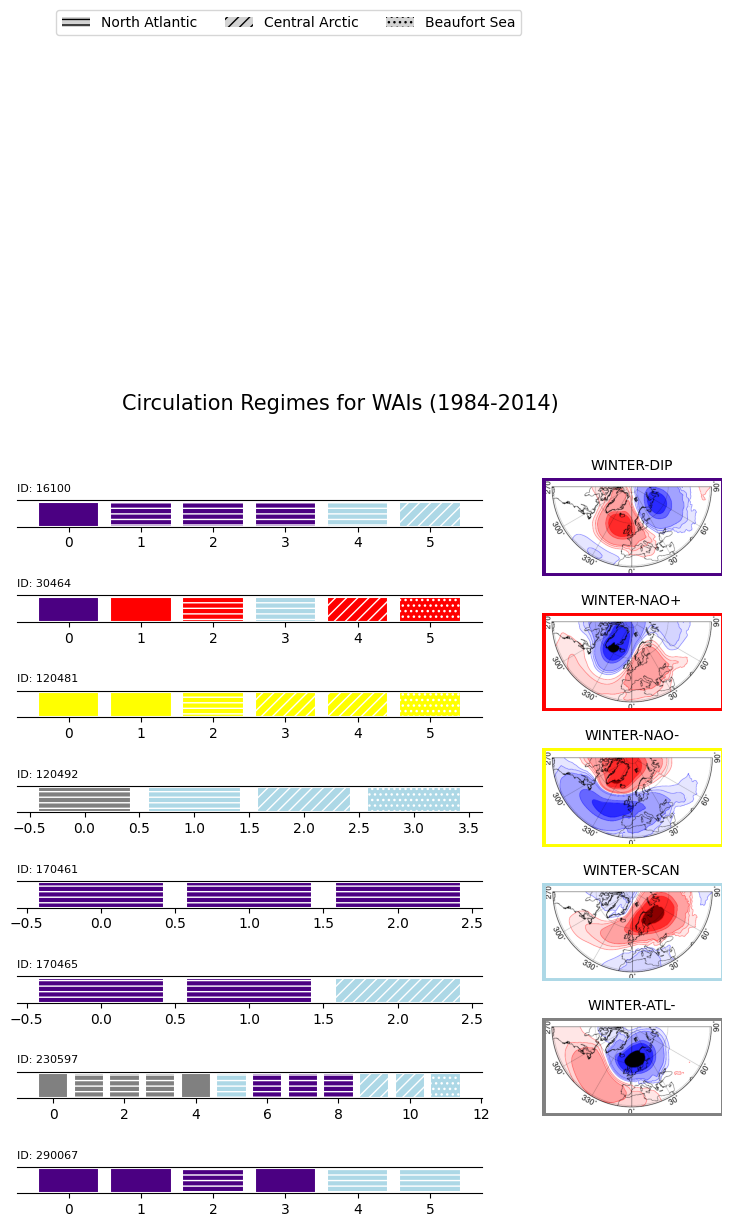

In [77]:
plot_circulation(df_NorESM_control_dates,objs_final,8,'1984-2014',regimes)

#### SSP

In [36]:
df_NorESM_ssp = xr.open_dataset('/work/aa0238/a271093/data/clustering/NorESM_ssp/NorESM_ICON_SSP_gph70000_2015_2100_reglonlat_-90_90_20_88_1deg_DJF_fldmean_detrend.nc')

In [37]:
df_NorESM_ssp_dates = pd.read_csv('/work/aa0238/a271093/data/clustering/regime_output/BMU/NorESM_ICON_SSP_gph70000_2015_2100_reglonlat_-90_90_20_88_1deg_DJF_fldmean_detrend_del29feb_aac_20PCs_5clusters_Ref_ERA5KmeansPCA.csv')

In [38]:
df_NorESM_ssp_dates['time'] = pd.to_datetime(df_NorESM_ssp_dates['time'])

In [ ]:
NA_bool = df_NorESM_ssp_dates['time'].isin(NA_combined_times_ssp)
CA_bool = df_NorESM_ssp_dates['time'].isin(CA_combined_times_ssp)
BS_bool = df_NorESM_ssp_dates['time'].isin(BS_combined_times_ssp)

In [ ]:
#Create new column for the df_atlantic_dates dataframe which shows if at that time, an object (objs_final) is in a certain domain
conditions = [NA_bool, CA_bool, BS_bool]
choices = ['NA', 'CA', 'BS']

df_NorESM_ssp_dates['domain'] = np.select(conditions, choices, default='NONE')
        

In [ ]:
df_NorESM_ssp_dates

In [ ]:
#Define regime colors and images in dictionary
rms = {
    '0: WINTER-DIP': {'color': 'red', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_1_upper_half_horizontal.png'},
    '1: WINTER-NAO+': {'color': 'lightblue', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_2_upper_half_horizontal.png'},
    '2: WINTER-NAO-': {'color': 'grey', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_3_upper_half_horizontal.png'},
    '3: WINTER-SCAN' : {'color': 'orange', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_4_upper_half_horizontal.png'},
    '4: WINTER-ATL-': {'color': 'indigo', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_5_upper_half_horizontal.png'}
}

#### 15-39

In [113]:
df_NorESM_ssp_dates_39 = pd.read_csv('/work/aa0238/a271093/data/clustering/regime_output/BMU/NorESM_ICON_SSP_gph70000_2015_2100_reglonlat_-90_90_20_88_1deg_DJF_fldmean_detrend_del29feb_aac_20PCs_5clusters_Ref_ERA5KmeansPCA.csv')

In [114]:
# Ensure time column is datetime
df_NorESM_ssp_dates_39['time'] = pd.to_datetime(df_NorESM_ssp_dates_39['time'])

# Filter for desired time range
df_NorESM_ssp_dates_39 = df_NorESM_ssp_dates_39[(df_NorESM_ssp_dates_39['time'] >= '2015-01-01 12:00:00') & (df_NorESM_ssp_dates_39['time'] <= '2039-12-31 12:00:00')]


In [115]:
NA_bool = df_NorESM_ssp_dates_39['time'].isin(NA_combined_times_39)
CA_bool = df_NorESM_ssp_dates_39['time'].isin(CA_combined_times_39)
BS_bool = df_NorESM_ssp_dates_39['time'].isin(BS_combined_times_39)

In [116]:
#Create new column for the df_atlantic_dates dataframe which shows if at that time, an object (objs_final) is in a certain domain
conditions = [NA_bool, CA_bool, BS_bool]
choices = ['NA', 'CA', 'BS']

df_NorESM_ssp_dates_39['domain'] = np.select(conditions, choices, default='NONE')
        

In [117]:
df_NorESM_ssp_dates_39

time  cluster_id cluster_name domain
0    2015-01-01 12:00:00           3  WINTER-SCAN   NONE
1    2015-01-02 12:00:00           3  WINTER-SCAN   NONE
2    2015-01-03 12:00:00           3  WINTER-SCAN   NONE
3    2015-01-04 12:00:00           3  WINTER-SCAN   NONE
4    2015-01-05 12:00:00           3  WINTER-SCAN   NONE
...                  ...         ...          ...    ...
2245 2039-12-27 12:00:00           0   WINTER-DIP   NONE
2246 2039-12-28 12:00:00           0   WINTER-DIP   NONE
2247 2039-12-29 12:00:00           0   WINTER-DIP   NONE
2248 2039-12-30 12:00:00           4  WINTER-ATL-   NONE
2249 2039-12-31 12:00:00           4  WINTER-ATL-   NONE

[2250 rows x 4 columns]

In [118]:
len(objs_final_15_39)

9

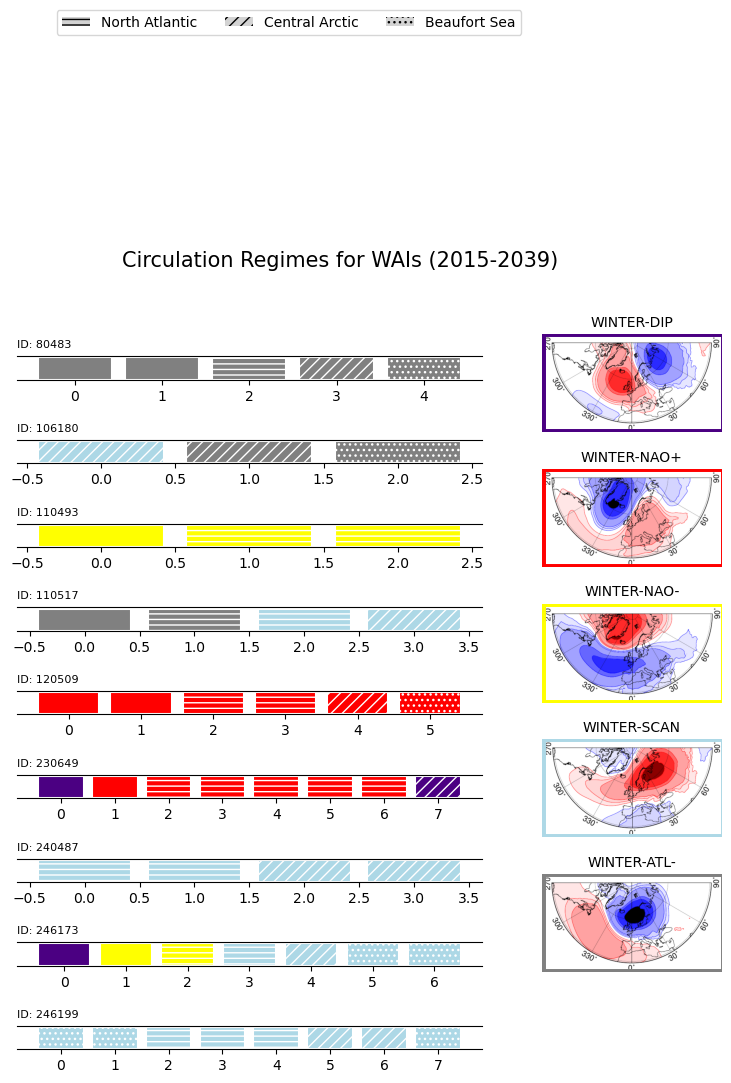

In [120]:
plot_circulation(df_NorESM_ssp_dates_39,objs_final_15_39,9,'2015-2039',regimes)

# Stats

In [ ]:
#Define regime colors and images in dictionary
regimes = {
    '0': {'color': 'indigo', 'image': f"{image_path}{image_file_map['djfm']['DIPOL']}",'name':'WINTER-DIP'},
    '1': {'color': 'red', 'image': f"{image_path}{image_file_map['djfm']['NAO+']}",'name':'WINTER-NAO+'},
    '2': {'color': 'yellow', 'image': f"{image_path}{image_file_map['djfm']['NAO-']}",'name':'WINTER-NAO-'},
    '3': {'color': 'lightblue', 'image': f"{image_path}{image_file_map['djfm']['SCAN']}",'name':'WINTER-SCAN'},
    '4': {'color': 'grey', 'image': f"{image_path}{image_file_map['djfm']['ATL-']}",'name':'WINTER-ATL-'}
}

##### CNRM-control

In [ ]:
plot_cluster_distribution(df_NorESM_control_dates, '1984-2014',['red', 'lightblue', 'grey', 'orange', 'indigo'])

#### CMRM-ssp

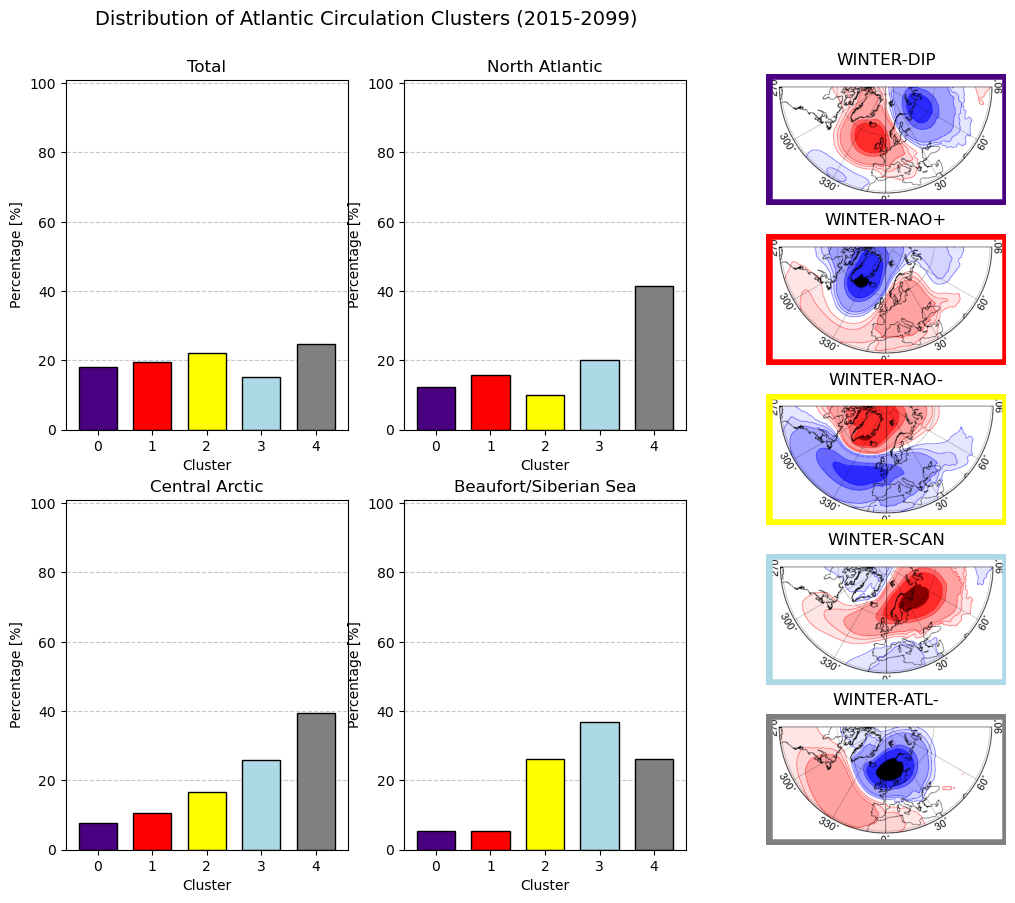

<Figure size 640x480 with 0 Axes>

In [90]:
plot_cluster_distribution(df_NorESM_ssp_dates, '2015-2099',['indigo', 'red', 'yellow', 'lightblue', 'grey'])

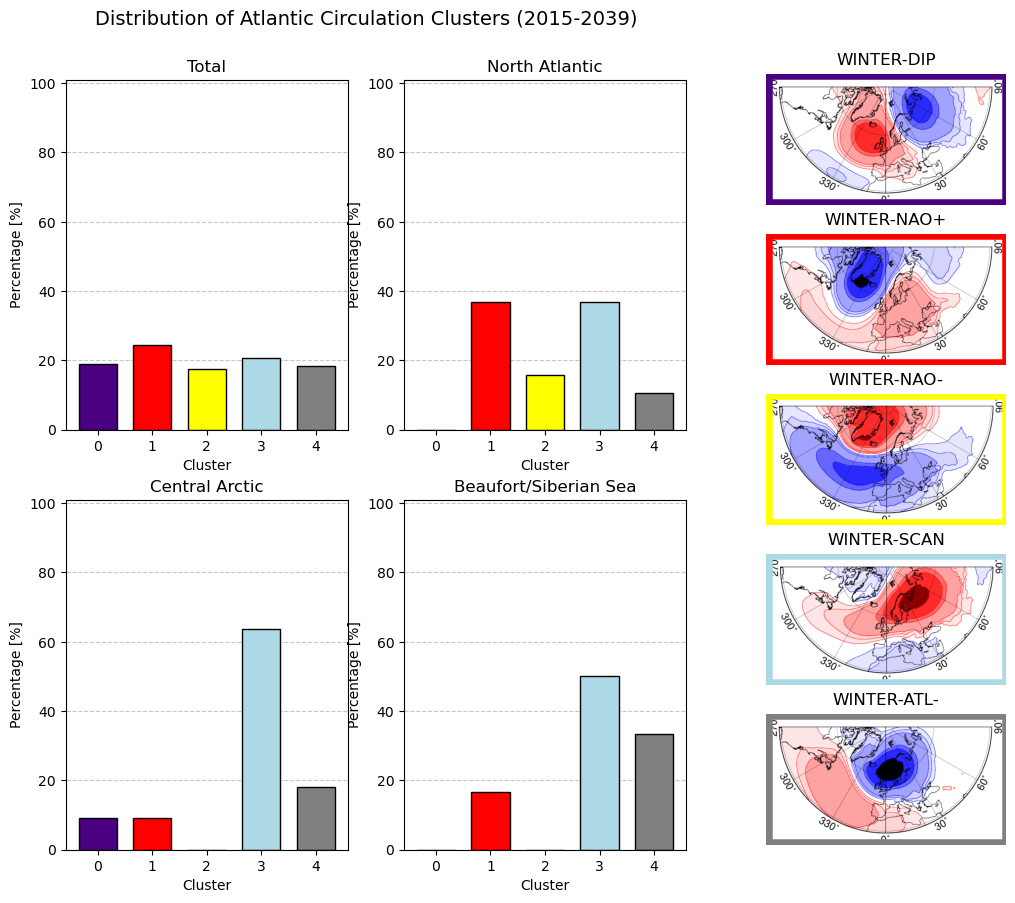

<Figure size 640x480 with 0 Axes>

In [137]:
plot_cluster_distribution(df_NorESM_ssp_dates_39, '2015-2039',['indigo', 'red', 'yellow', 'lightblue', 'grey'])

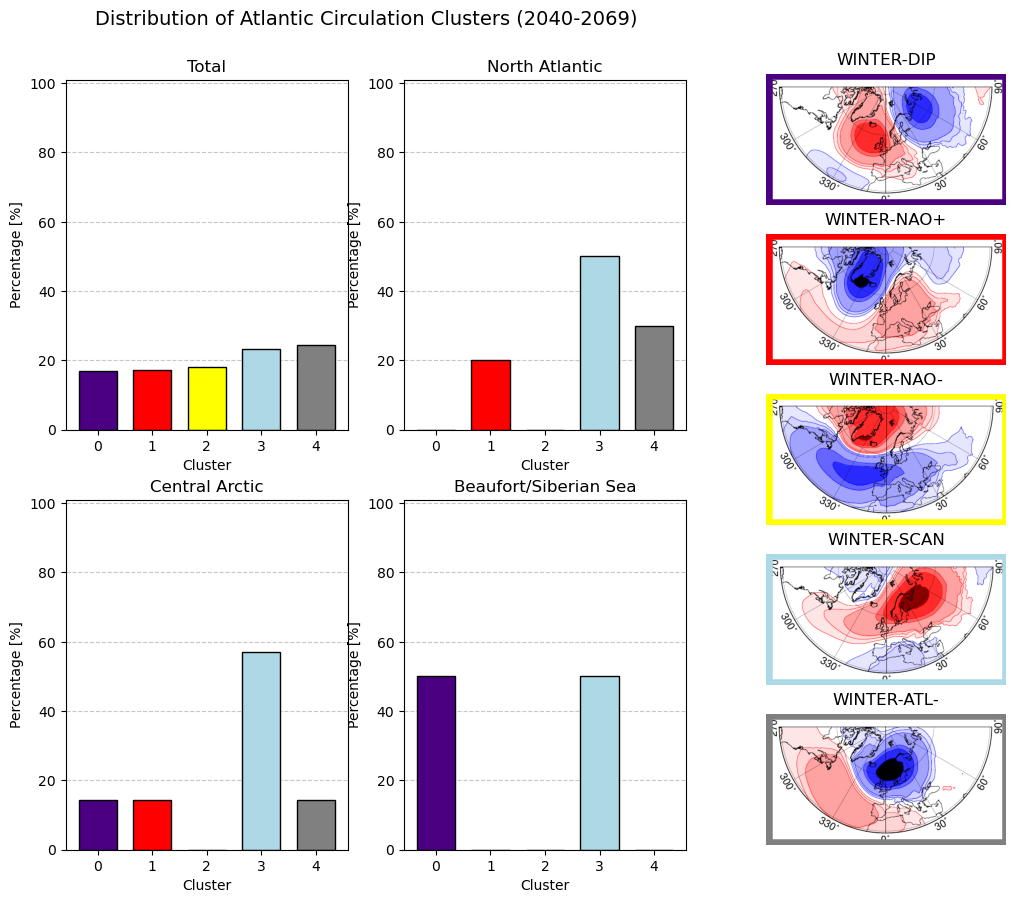

<Figure size 640x480 with 0 Axes>

In [138]:
plot_cluster_distribution(df_NorESM_ssp_dates_69, '2040-2069',['indigo', 'red', 'yellow', 'lightblue', 'grey'])

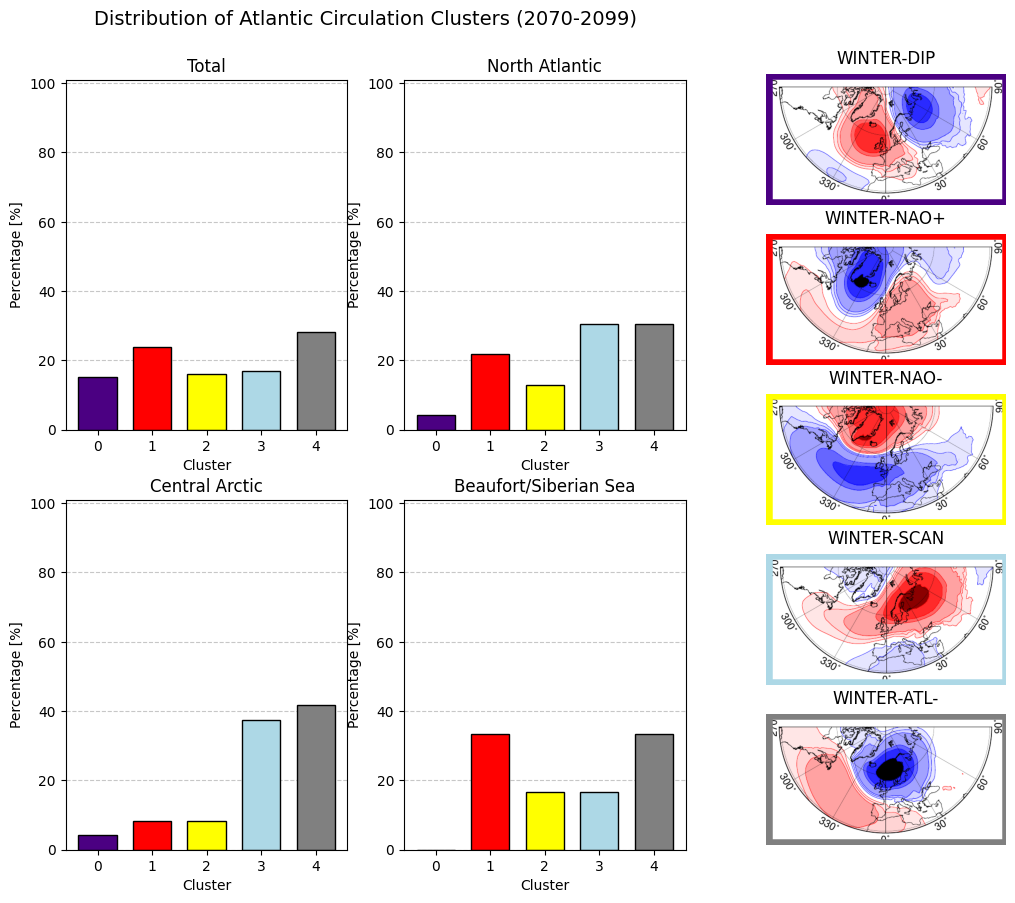

<Figure size 640x480 with 0 Axes>

In [87]:
plot_cluster_distribution(df_NorESM_ssp_dates_99, '2070-2099',['indigo', 'red', 'yellow', 'lightblue', 'grey'])

### Hourly Clusters

In [ ]:
# Here, the cluster information is taken from MOAAP 

In [24]:
atlantic_regimes = {
    '1': {'name':'WINTER-NAO+','color': '#FB9A99', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_1_upper_half_horizontal.png'},
    '2': {'name':'WINTER-SCAN','color': '#A6CEE3', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_2_upper_half_horizontal.png'},
    '3': {'name':'WINTER-ATL-','color': 'navy', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_3_upper_half_horizontal.png'},
    '4': {'name':'WINTER-NAO-','color': '#CAB2D6', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_4_upper_half_horizontal.png'},
    '5': {'name':'WINTER-DIP','color': '#B2DF8A', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_5_upper_half_horizontal.png'}
}


#### Control

In [25]:
df_data_ctrl = create_df_cluster_info(objs_final, NA_combined_times, CA_combined_times, BS_combined_times)
df_data_ctrl

date cluster_names domain cluster_id
0    1985-12-23 11:00:00    WINTER-DIP   NONE          5
1    1985-12-23 12:00:00    WINTER-DIP   NONE          5
2    1985-12-23 13:00:00    WINTER-DIP   NONE          5
3    1985-12-23 14:00:00    WINTER-DIP   NONE          5
4    1985-12-23 15:00:00    WINTER-DIP   NONE          5
...                  ...           ...    ...        ...
1128 2013-02-22 19:00:00   WINTER-SCAN     BS          2
1129 2013-02-22 20:00:00   WINTER-SCAN     BS          2
1130 2013-02-22 21:00:00   WINTER-SCAN     BS          2
1131 2013-02-22 22:00:00   WINTER-SCAN     BS          2
1132 2013-02-22 23:00:00   WINTER-SCAN     BS          2

[1133 rows x 4 columns]

In [26]:
#Cluster climatology cannot be from MOAAP, has to be from df_NorESM_control_dates
DIP = df_NorESM_control_dates['cluster_name'] == 'WINTER-DIP'
NAOplus = df_NorESM_control_dates['cluster_name'] == 'WINTER-NAO+'
NAOminus = df_NorESM_control_dates['cluster_name'] == 'WINTER-NAO-'
SCAN = df_NorESM_control_dates['cluster_name'] == 'WINTER-SCAN'
ATLminus = df_NorESM_control_dates['cluster_name'] == 'WINTER-ATL-'

conditions = [NAOplus,SCAN,ATLminus,NAOminus,DIP]
choices = [1,2,3,4,5]

df_NorESM_control_dates['cluster_id']=np.select(conditions,choices,default='NONE')

df_NorESM_control_dates

time cluster_id cluster_name domain
0    1984-01-01 12:00:00          4  WINTER-NAO-   NONE
1    1984-01-02 12:00:00          4  WINTER-NAO-   NONE
2    1984-01-03 12:00:00          4  WINTER-NAO-   NONE
3    1984-01-04 12:00:00          4  WINTER-NAO-   NONE
4    1984-01-05 12:00:00          4  WINTER-NAO-   NONE
...                  ...        ...          ...    ...
2785 2014-12-27 12:00:00          5   WINTER-DIP   NONE
2786 2014-12-28 12:00:00          4  WINTER-NAO-   NONE
2787 2014-12-29 12:00:00          4  WINTER-NAO-   NONE
2788 2014-12-30 12:00:00          4  WINTER-NAO-   NONE
2789 2014-12-31 12:00:00          3  WINTER-ATL-   NONE

[2790 rows x 4 columns]

In [27]:
#Count Regime Occurrence
counts_all = compute_cluster_counts(df_NorESM_control_dates, ['1','2','3','4','5'])
counts_NA = compute_cluster_counts(df_data_ctrl[df_data_ctrl['domain'] == 'NA'], ['1','2','3','4','5'])
counts_CA = compute_cluster_counts(df_data_ctrl[df_data_ctrl['domain'] == 'CA'], ['1','2','3','4','5'])
counts_BS = compute_cluster_counts(df_data_ctrl[df_data_ctrl['domain'] == 'BS'], ['1','2','3','4','5'])

# List of all counts
all_counts = [counts_all, counts_NA, counts_CA, counts_BS]


In [28]:
counts_all

[20.7168458781362,
 17.096774193548388,
 21.433691756272403,
 19.56989247311828,
 21.182795698924732]

In [30]:
named_cluster_weights = get_normalized_frequency(df_data_ctrl)
named_cluster_weights

{'NA': {'WINTER-NAO+': 6.379585326953747,
  'WINTER-SCAN': 28.07017543859649,
  'WINTER-ATL-': 17.065390749601274,
  'WINTER-NAO-': 6.0606060606060606,
  'WINTER-DIP': 42.42424242424242},
 'CA': {'WINTER-NAO+': 11.881188118811881,
  'WINTER-SCAN': 65.34653465346535,
  'WINTER-ATL-': 0.0,
  'WINTER-NAO-': 15.841584158415841,
  'WINTER-DIP': 6.9306930693069315},
 'BS': {'WINTER-NAO+': 2.857142857142857,
  'WINTER-SCAN': 57.14285714285714,
  'WINTER-ATL-': 0.0,
  'WINTER-NAO-': 40.0,
  'WINTER-DIP': 0.0}}

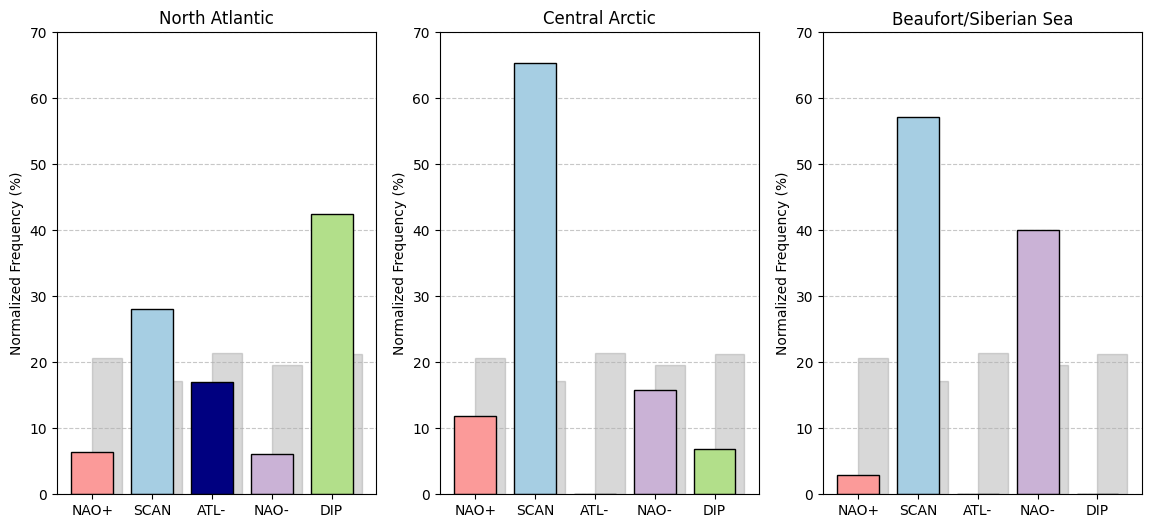

In [31]:
plot_hourly_hist(named_cluster_weights,counts_all,'control',NorESM=True)

#### 70-99

In [66]:
df_data_70_99 = create_df_cluster_info(objs_final_70_99, NA_combined_times_99, CA_combined_times_99, BS_combined_times_99)
df_data_70_99

In [68]:
DIP = df_NorESM_ssp_dates_99['cluster_name'] == 'WINTER-DIP'
NAOplus = df_NorESM_ssp_dates_99['cluster_name'] == 'WINTER-NAO+'
NAOminus = df_NorESM_ssp_dates_99['cluster_name'] == 'WINTER-NAO-'
SCAN = df_NorESM_ssp_dates_99['cluster_name'] == 'WINTER-SCAN'
ATLminus = df_NorESM_ssp_dates_99['cluster_name'] == 'WINTER-ATL-'

conditions = [NAOplus,SCAN,ATLminus,NAOminus,DIP]
choices = [1,2,3,4,5]

df_NorESM_ssp_dates_99['cluster_id']=np.select(conditions,choices,default='NONE')

df_NorESM_ssp_dates_99

time cluster_id cluster_name domain
4950 2070-01-01 12:00:00          1  WINTER-NAO+   NONE
4951 2070-01-02 12:00:00          1  WINTER-NAO+   NONE
4952 2070-01-03 12:00:00          1  WINTER-NAO+   NONE
4953 2070-01-04 12:00:00          1  WINTER-NAO+   NONE
4954 2070-01-05 12:00:00          1  WINTER-NAO+   NONE
...                  ...        ...          ...    ...
7645 2099-12-27 12:00:00          2  WINTER-SCAN   NONE
7646 2099-12-28 12:00:00          2  WINTER-SCAN   NONE
7647 2099-12-29 12:00:00          2  WINTER-SCAN   NONE
7648 2099-12-30 12:00:00          2  WINTER-SCAN   NONE
7649 2099-12-31 12:00:00          2  WINTER-SCAN   NONE

[2700 rows x 4 columns]

In [69]:
#Count Regime Occurrence
counts_all = compute_cluster_counts(df_NorESM_ssp_dates_99, ['1','2','3','4','5'])
counts_NA = compute_cluster_counts(df_data_70_99[df_data_70_99['domain'] == 'NA'], ['1','2','3','4','5'])
counts_CA = compute_cluster_counts(df_data_70_99[df_data_70_99['domain'] == 'CA'], ['1','2','3','4','5'])
counts_BS = compute_cluster_counts(df_data_70_99[df_data_70_99['domain'] == 'BS'], ['1','2','3','4','5'])

# List of all counts
all_counts = [counts_all, counts_NA, counts_CA, counts_BS]

In [72]:
counts_all 

[23.814814814814813,
 16.925925925925924,
 28.14814814814815,
 15.962962962962962,
 15.148148148148149]

In [ ]:
named_cluster_weights = get_normalized_frequency(df_data_70_99)
named_cluster_weights

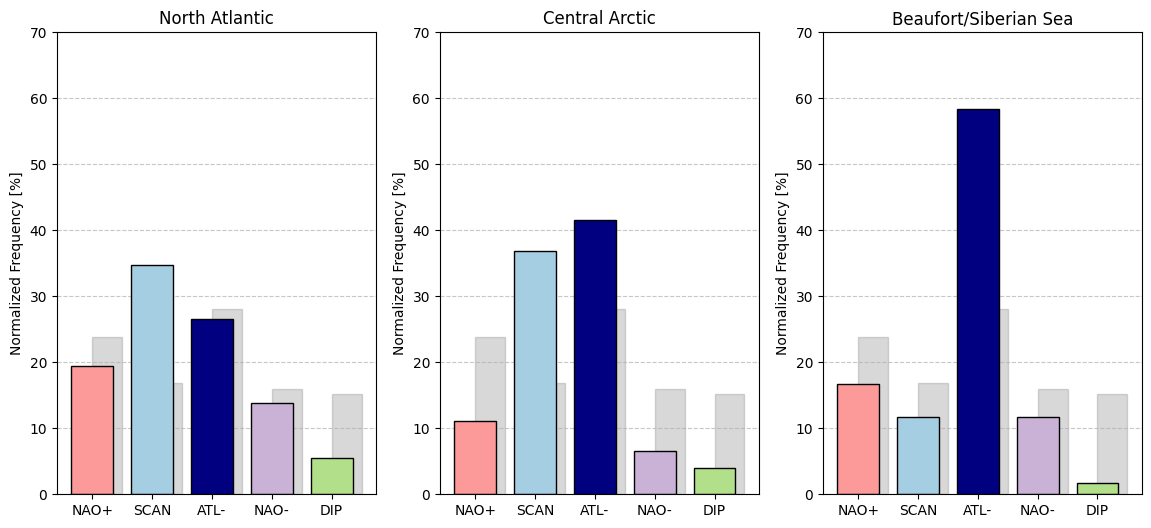

In [71]:
plot_hourly_hist(named_cluster_weights,counts_all,'70_99',NorESM=True)

## Tracks

In [107]:
arctic_cluster_path = '/work/aa0049/a271122/ERA5/CirculationRegime_clusters/'

/tmp/ipykernel_857412/3542492684.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab20b", len(objs_final))  # You can try "plasma", "cividis", etc.


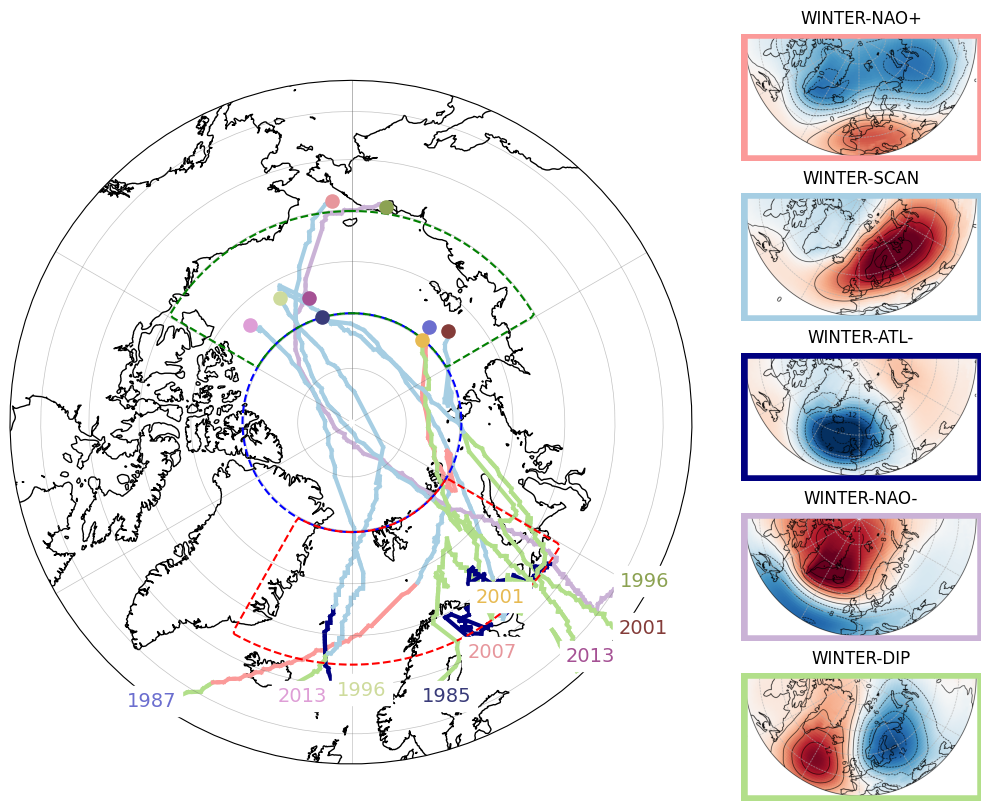

In [108]:
##ORIGINAL DO NOT CHANGE
fig,ax=plt.subplots(1,1,subplot_kw={'projection': ccrs.Orthographic(0,90)},figsize=(8,10))
objs_nr=len(objs_final)
# Define your regime colors
# 2. Choose a sequential colormap and sample it
cmap = cm.get_cmap("tab20b", len(objs_final))  # You can try "plasma", "cividis", etc.
obj_color_all = [cmap(i) for i in range(len(objs_final))]
atlantic_regimes = {
    'WINTER-NAO+': {'color': '#FB9A99', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_1_upper_half_horizontal.png'},
    'WINTER-SCAN': {'color': '#A6CEE3', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_2_upper_half_horizontal.png'},
    'WINTER-ATL-': {'color': 'navy', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_3_upper_half_horizontal.png'},
    'WINTER-NAO-': {'color': '#CAB2D6', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_4_upper_half_horizontal.png'},
    'WINTER-DIP': {'color': '#B2DF8A', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_5_upper_half_horizontal.png'}
}

for ii in range(len(objs_final)):
    cluster_values = objs_final[ii].clusters.values
    #print(cluster_values)
    track=objs_final[ii].track.values
    
    track_lats = np.array([x.lat for x in track])
    track_lons = np.array([x.lon for x in track])    


    obj_id=objs_final[ii]['id_'].item()
    obj_color = obj_color_all[ii]
    #obj_color=df_objs[  df_objs['id'] == obj_id].color.item()
    #ax.text(track_lons[-1],track_lats[-1],obj_id,fontsize=14,backgroundcolor='white',transform=crs_rot,color=obj_color,zorder=11)
    ax.text(track_lons[0],track_lats[0],str(pd.to_datetime(objs_final[ii]['times'][0].values).strftime('%Y')),fontsize=14,
            transform=crs_rot,color=obj_color,backgroundcolor='white',zorder=11) #color=obj_color
    #ax.scatter(track_lons[-1],track_lats[-1],facecolor='k',edgecolor='k',transform=crs_rot)
    ax.scatter(track_lons[-1],track_lats[-1],facecolor=obj_color,edgecolor=obj_color,transform=crs_rot,s=90,zorder =12)
    
    #ax.scatter(track_lons,track_lats,color=obj_color,transform=crs_rot)  
    #ax.plot(track_lons , track_lats ,color='k', transform = crs_rot,linewidth=3)

    for j in range(len(track_lats) - 1):
        #if np.isnan(cluster_values[j]):
        #    ax.plot(track_lons[j:j+2], track_lats[j:j+2], color='grey', transform=crs_rot, linewidth=2)
        #else:
        cluster_label = cluster_values[j]
        color = atlantic_regimes.get(cluster_label, {}).get('color', 'grey')
        ax.plot(track_lons[j:j+2], track_lats[j:j+2], color=color, transform=crs_rot, linewidth=3)

    
#duration_mean=np.array([len(obj.times) for obj in objs_final]).mean()
#this marks the domain (North Atlantic, Central Arctic and Beaufort area) 
for domain_name, domain_data in mask_domains.items():
    domain_data["mask"].plot.contour(levels=1,colors=domain_data["color"],linewidths=1.5,linestyles='--',zorder=4,ax=ax,transform=ccrs.PlateCarree())



#ax.text(0.02, 0.02, f'nr: {objs_nr}, duration: {int(np.round(duration_mean))}h',
#        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
ax.coastlines()

ax.set_extent([-180,180, 60, 90], crs=ccrs.PlateCarree())
ax.gridlines(linewidth=0.5,color='dimgray',alpha=0.4,zorder=2)#,draw_labels=True)
#ax.set_title('ERA5 1979-2022',loc='left',y=1)
# Clip to circle
center, radius = [0.5, 0.5], 0.55
circle = mpath.Path(np.vstack([np.sin(np.linspace(0, 2*np.pi, 100)),
                               np.cos(np.linspace(0, 2*np.pi, 100))]).T * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


#fig.suptitle('IVT-Object tracks and associated synoptic pattern ERA5 1979-2022 in DJF', fontweight='bold',y=0.9)



# Add images as legend

image_positions = [0.67, 0.51, 0.35, 0.19, 0.03]  # Vertical
width = 0.3
height = 0.3

for i, (name, info) in enumerate(atlantic_regimes.items()):
    img = mpimg.imread(info['image'])
    
    #positions
    ax_img = fig.add_axes([1.0, image_positions[i], width, height])  #[left, bottom, width, height]
    ax_img.imshow(img)
    ax_img.axis('off')
    
    #Add frame and regime title
    rect = Rectangle((0, 0), 1.01, 1.01, linewidth=9, edgecolor=info['color'], facecolor='none', transform=ax_img.transAxes)
    ax_img.add_patch(rect)
    ax_img.text(0.5, 1.05, f'{name}', ha='center', va='bottom', fontsize=12, color='k', transform=ax_img.transAxes)


#plt.savefig('/work/aa0049/a271122/ERA5/CirculationRegime_clusters/tracks_ERA5.png', bbox_inches='tight', dpi=300)
plt.show()

# ORIGINAL DO NOT CHANGE

NameError: name 'objs_final_15_39' is not defined

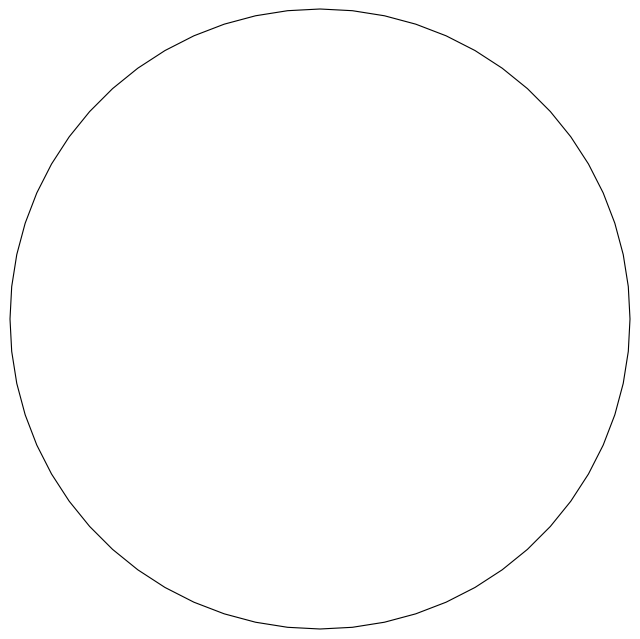

In [109]:
##ORIGINAL DO NOT CHANGE
fig,ax=plt.subplots(1,1,subplot_kw={'projection': ccrs.Orthographic(0,90)},figsize=(8,10))
objs_nr=len(objs_final_15_39)
# Define your regime colors
# 2. Choose a sequential colormap and sample it
cmap = cm.get_cmap("tab20b", len(objs_final_15_39))  # You can try "plasma", "cividis", etc.
obj_color_all = [cmap(i) for i in range(len(objs_final_15_39))]
atlantic_regimes = {
    'WINTER-NAO+': {'color': '#FB9A99', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_1_upper_half_horizontal.png'},
    'WINTER-SCAN': {'color': '#A6CEE3', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_2_upper_half_horizontal.png'},
    'WINTER-ATL-': {'color': 'navy', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_3_upper_half_horizontal.png'},
    'WINTER-NAO-': {'color': '#CAB2D6', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_4_upper_half_horizontal.png'},
    'WINTER-DIP': {'color': '#B2DF8A', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_5_upper_half_horizontal.png'}
}

for ii in range(len(objs_final_15_39)):
    cluster_values = objs_final_15_39[ii].clusters.values
    #print(cluster_values)
    track=objs_final_15_39[ii].track.values
    
    track_lats = np.array([x.lat for x in track])
    track_lons = np.array([x.lon for x in track])    


    obj_id=objs_final_15_39[ii]['id_'].item()
    obj_color = obj_color_all[ii]
    #obj_color=df_objs[  df_objs['id'] == obj_id].color.item()
    #ax.text(track_lons[-1],track_lats[-1],obj_id,fontsize=14,backgroundcolor='white',transform=crs_rot,color=obj_color,zorder=11)
    ax.text(track_lons[0],track_lats[0],str(pd.to_datetime(objs_final_15_39[ii]['times'][0].values).strftime('%Y')),fontsize=14,
            transform=crs_rot,color=obj_color,backgroundcolor='white',zorder=11) #color=obj_color
    #ax.scatter(track_lons[-1],track_lats[-1],facecolor='k',edgecolor='k',transform=crs_rot)
    ax.scatter(track_lons[-1],track_lats[-1],facecolor=obj_color,edgecolor=obj_color,transform=crs_rot,s=90,zorder =12)
    
    #ax.scatter(track_lons,track_lats,color=obj_color,transform=crs_rot)  
    #ax.plot(track_lons , track_lats ,color='k', transform = crs_rot,linewidth=3)

    for j in range(len(track_lats) - 1):
        #if np.isnan(cluster_values[j]):
        #    ax.plot(track_lons[j:j+2], track_lats[j:j+2], color='grey', transform=crs_rot, linewidth=2)
        #else:
        cluster_label = cluster_values[j]
        color = atlantic_regimes.get(cluster_label, {}).get('color', 'grey')
        ax.plot(track_lons[j:j+2], track_lats[j:j+2], color=color, transform=crs_rot, linewidth=3)

    
#duration_mean=np.array([len(obj.times) for obj in objs_final_15_39]).mean()
#this marks the domain (North Atlantic, Central Arctic and Beaufort area) 
for domain_name, domain_data in mask_domains.items():
    domain_data["mask"].plot.contour(levels=1,colors=domain_data["color"],linewidths=1.5,linestyles='--',zorder=4,ax=ax,transform=ccrs.PlateCarree())



#ax.text(0.02, 0.02, f'nr: {objs_nr}, duration: {int(np.round(duration_mean))}h',
#        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
ax.coastlines()

ax.set_extent([-180,180, 60, 90], crs=ccrs.PlateCarree())
ax.gridlines(linewidth=0.5,color='dimgray',alpha=0.4,zorder=2)#,draw_labels=True)
#ax.set_title('ERA5 1979-2022',loc='left',y=1)
# Clip to circle
center, radius = [0.5, 0.5], 0.55
circle = mpath.Path(np.vstack([np.sin(np.linspace(0, 2*np.pi, 100)),
                               np.cos(np.linspace(0, 2*np.pi, 100))]).T * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


#fig.suptitle('IVT-Object tracks and associated synoptic pattern ERA5 1979-2022 in DJF', fontweight='bold',y=0.9)



# Add images as legend

image_positions = [0.67, 0.51, 0.35, 0.19, 0.03]  # Vertical
width = 0.3
height = 0.3

for i, (name, info) in enumerate(atlantic_regimes.items()):
    img = mpimg.imread(info['image'])
    
    #positions
    ax_img = fig.add_axes([1.0, image_positions[i], width, height])  #[left, bottom, width, height]
    ax_img.imshow(img)
    ax_img.axis('off')
    
    #Add frame and regime title
    rect = Rectangle((0, 0), 1.01, 1.01, linewidth=9, edgecolor=info['color'], facecolor='none', transform=ax_img.transAxes)
    ax_img.add_patch(rect)
    ax_img.text(0.5, 1.05, f'{name}', ha='center', va='bottom', fontsize=12, color='k', transform=ax_img.transAxes)


#plt.savefig('/work/aa0049/a271122/ERA5/CirculationRegime_clusters/tracks_ERA5.png', bbox_inches='tight', dpi=300)
plt.show()

# ORIGINAL DO NOT CHANGE


In [ ]:
##ORIGINAL DO NOT CHANGE
fig,ax=plt.subplots(1,1,subplot_kw={'projection': ccrs.Orthographic(0,90)},figsize=(8,10))
objs_nr=len(objs_final_40_69)
# Define your regime colors
# 2. Choose a sequential colormap and sample it
cmap = cm.get_cmap("tab20b", len(objs_final_40_69))  # You can try "plasma", "cividis", etc.
obj_color_all = [cmap(i) for i in range(len(objs_final_40_69))]
atlantic_regimes = {
    'WINTER-NAO+': {'color': '#FB9A99', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_1_upper_half_horizontal.png'},
    'WINTER-SCAN': {'color': '#A6CEE3', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_2_upper_half_horizontal.png'},
    'WINTER-ATL-': {'color': 'navy', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_3_upper_half_horizontal.png'},
    'WINTER-NAO-': {'color': '#CAB2D6', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_4_upper_half_horizontal.png'},
    'WINTER-DIP': {'color': '#B2DF8A', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_5_upper_half_horizontal.png'}
}

for ii in range(len(objs_final_40_69)):
    cluster_values = objs_final_40_69[ii].clusters.values
    #print(cluster_values)
    track=objs_final_40_69[ii].track.values
    
    track_lats = np.array([x.lat for x in track])
    track_lons = np.array([x.lon for x in track])    


    obj_id=objs_final_40_69[ii]['id_'].item()
    obj_color = obj_color_all[ii]
    #obj_color=df_objs[  df_objs['id'] == obj_id].color.item()
    #ax.text(track_lons[-1],track_lats[-1],obj_id,fontsize=14,backgroundcolor='white',transform=crs_rot,color=obj_color,zorder=11)
    ax.text(track_lons[0],track_lats[0],str(pd.to_datetime(objs_final_40_69[ii]['times'][0].values).strftime('%Y')),fontsize=14,
            transform=crs_rot,color=obj_color,backgroundcolor='white',zorder=11) #color=obj_color
    #ax.scatter(track_lons[-1],track_lats[-1],facecolor='k',edgecolor='k',transform=crs_rot)
    ax.scatter(track_lons[-1],track_lats[-1],facecolor=obj_color,edgecolor=obj_color,transform=crs_rot,s=90,zorder =12)
    
    #ax.scatter(track_lons,track_lats,color=obj_color,transform=crs_rot)  
    #ax.plot(track_lons , track_lats ,color='k', transform = crs_rot,linewidth=3)

    for j in range(len(track_lats) - 1):
        #if np.isnan(cluster_values[j]):
        #    ax.plot(track_lons[j:j+2], track_lats[j:j+2], color='grey', transform=crs_rot, linewidth=2)
        #else:
        cluster_label = cluster_values[j]
        color = atlantic_regimes.get(cluster_label, {}).get('color', 'grey')
        ax.plot(track_lons[j:j+2], track_lats[j:j+2], color=color, transform=crs_rot, linewidth=3)

    
#duration_mean=np.array([len(obj.times) for obj in objs_final_40_69]).mean()
#this marks the domain (North Atlantic, Central Arctic and Beaufort area) 
for domain_name, domain_data in mask_domains.items():
    domain_data["mask"].plot.contour(levels=1,colors=domain_data["color"],linewidths=1.5,linestyles='--',zorder=4,ax=ax,transform=ccrs.PlateCarree())



#ax.text(0.02, 0.02, f'nr: {objs_nr}, duration: {int(np.round(duration_mean))}h',
#        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
ax.coastlines()

ax.set_extent([-180,180, 60, 90], crs=ccrs.PlateCarree())
ax.gridlines(linewidth=0.5,color='dimgray',alpha=0.4,zorder=2)#,draw_labels=True)
#ax.set_title('ERA5 1979-2022',loc='left',y=1)
# Clip to circle
center, radius = [0.5, 0.5], 0.55
circle = mpath.Path(np.vstack([np.sin(np.linspace(0, 2*np.pi, 100)),
                               np.cos(np.linspace(0, 2*np.pi, 100))]).T * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


#fig.suptitle('IVT-Object tracks and associated synoptic pattern ERA5 1979-2022 in DJF', fontweight='bold',y=0.9)



# Add images as legend

image_positions = [0.67, 0.51, 0.35, 0.19, 0.03]  # Vertical
width = 0.3
height = 0.3

for i, (name, info) in enumerate(atlantic_regimes.items()):
    img = mpimg.imread(info['image'])
    
    #positions
    ax_img = fig.add_axes([1.0, image_positions[i], width, height])  #[left, bottom, width, height]
    ax_img.imshow(img)
    ax_img.axis('off')
    
    #Add frame and regime title
    rect = Rectangle((0, 0), 1.01, 1.01, linewidth=9, edgecolor=info['color'], facecolor='none', transform=ax_img.transAxes)
    ax_img.add_patch(rect)
    ax_img.text(0.5, 1.05, f'{name}', ha='center', va='bottom', fontsize=12, color='k', transform=ax_img.transAxes)


#plt.savefig('/work/aa0049/a271122/ERA5/CirculationRegime_clusters/tracks_ERA5.png', bbox_inches='tight', dpi=300)
plt.show()

# ORIGINAL DO NOT CHANGE



/tmp/ipykernel_2188685/692433302.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab20b", len(objs_final_70_99))  # You can try "plasma", "cividis", etc.


FileNotFoundError: [Errno 2] No such file or directory: '/work/aa0049/a271122/ICON_ERA5/CirculationRegime_clusters//regime_images/djf_atlantic_cluster_1_upper_half_horizontal.png'

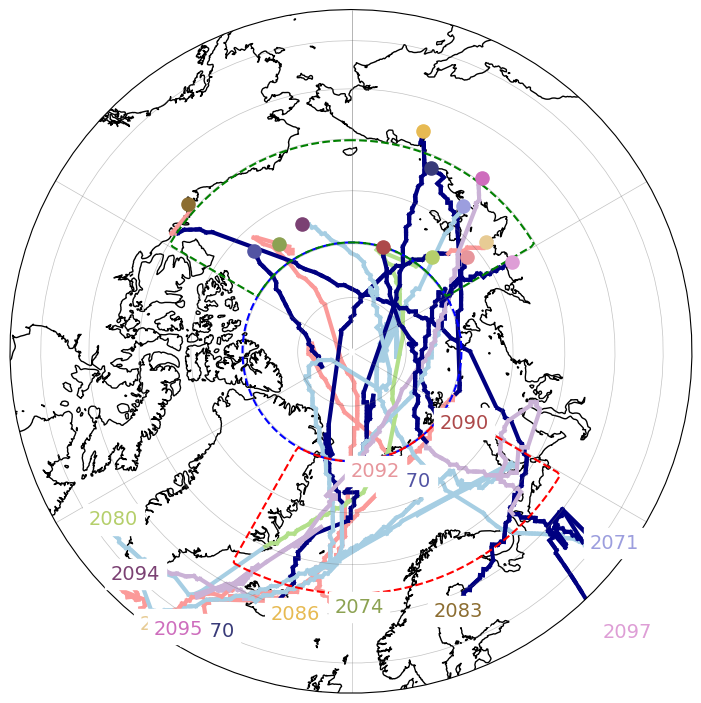

In [74]:

##ORIGINAL DO NOT CHANGE
fig,ax=plt.subplots(1,1,subplot_kw={'projection': ccrs.Orthographic(0,90)},figsize=(8,10))
objs_nr=len(objs_final_70_99)
# Define your regime colors
# 2. Choose a sequential colormap and sample it
cmap = cm.get_cmap("tab20b", len(objs_final_70_99))  # You can try "plasma", "cividis", etc.
obj_color_all = [cmap(i) for i in range(len(objs_final_70_99))]
atlantic_regimes = {
    'WINTER-NAO+': {'color': '#FB9A99', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_1_upper_half_horizontal.png'},
    'WINTER-SCAN': {'color': '#A6CEE3', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_2_upper_half_horizontal.png'},
    'WINTER-ATL-': {'color': 'navy', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_3_upper_half_horizontal.png'},
    'WINTER-NAO-': {'color': '#CAB2D6', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_4_upper_half_horizontal.png'},
    'WINTER-DIP': {'color': '#B2DF8A', 'image': f'{arctic_cluster_path}/regime_images/djf_atlantic_cluster_5_upper_half_horizontal.png'}
}

for ii in range(len(objs_final_70_99)):
    cluster_values = objs_final_70_99[ii].clusters.values
    #print(cluster_values)
    track=objs_final_70_99[ii].track.values
    
    track_lats = np.array([x.lat for x in track])
    track_lons = np.array([x.lon for x in track])    


    obj_id=objs_final_70_99[ii]['id_'].item()
    obj_color = obj_color_all[ii]
    #obj_color=df_objs[  df_objs['id'] == obj_id].color.item()
    #ax.text(track_lons[-1],track_lats[-1],obj_id,fontsize=14,backgroundcolor='white',transform=crs_rot,color=obj_color,zorder=11)
    ax.text(track_lons[0],track_lats[0],str(pd.to_datetime(objs_final_70_99[ii]['times'][0].values).strftime('%Y')),fontsize=14,
            transform=crs_rot,color=obj_color,backgroundcolor='white',zorder=11) #color=obj_color
    #ax.scatter(track_lons[-1],track_lats[-1],facecolor='k',edgecolor='k',transform=crs_rot)
    ax.scatter(track_lons[-1],track_lats[-1],facecolor=obj_color,edgecolor=obj_color,transform=crs_rot,s=90,zorder =12)
    
    #ax.scatter(track_lons,track_lats,color=obj_color,transform=crs_rot)  
    #ax.plot(track_lons , track_lats ,color='k', transform = crs_rot,linewidth=3)

    for j in range(len(track_lats) - 1):
        #if np.isnan(cluster_values[j]):
        #    ax.plot(track_lons[j:j+2], track_lats[j:j+2], color='grey', transform=crs_rot, linewidth=2)
        #else:
        cluster_label = cluster_values[j]
        color = atlantic_regimes.get(cluster_label, {}).get('color', 'grey')
        ax.plot(track_lons[j:j+2], track_lats[j:j+2], color=color, transform=crs_rot, linewidth=3)

    
#duration_mean=np.array([len(obj.times) for obj in objs_final_70_99]).mean()
#this marks the domain (North Atlantic, Central Arctic and Beaufort area) 
for domain_name, domain_data in mask_domains.items():
    domain_data["mask"].plot.contour(levels=1,colors=domain_data["color"],linewidths=1.5,linestyles='--',zorder=4,ax=ax,transform=ccrs.PlateCarree())



#ax.text(0.02, 0.02, f'nr: {objs_nr}, duration: {int(np.round(duration_mean))}h',
#        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
ax.coastlines()

ax.set_extent([-180,180, 60, 90], crs=ccrs.PlateCarree())
ax.gridlines(linewidth=0.5,color='dimgray',alpha=0.4,zorder=2)#,draw_labels=True)
#ax.set_title('ERA5 1979-2022',loc='left',y=1)
# Clip to circle
center, radius = [0.5, 0.5], 0.55
circle = mpath.Path(np.vstack([np.sin(np.linspace(0, 2*np.pi, 100)),
                               np.cos(np.linspace(0, 2*np.pi, 100))]).T * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


#fig.suptitle('IVT-Object tracks and associated synoptic pattern ERA5 1979-2022 in DJF', fontweight='bold',y=0.9)



# Add images as legend

image_positions = [0.67, 0.51, 0.35, 0.19, 0.03]  # Vertical
width = 0.3
height = 0.3

for i, (name, info) in enumerate(atlantic_regimes.items()):
    img = mpimg.imread(info['image'])
    
    #positions
    ax_img = fig.add_axes([1.0, image_positions[i], width, height])  #[left, bottom, width, height]
    ax_img.imshow(img)
    ax_img.axis('off')
    
    #Add frame and regime title
    rect = Rectangle((0, 0), 1.01, 1.01, linewidth=9, edgecolor=info['color'], facecolor='none', transform=ax_img.transAxes)
    ax_img.add_patch(rect)
    ax_img.text(0.5, 1.05, f'{name}', ha='center', va='bottom', fontsize=12, color='k', transform=ax_img.transAxes)


#plt.savefig('/work/aa0049/a271122/ERA5/CirculationRegime_clusters/tracks_ERA5.png', bbox_inches='tight', dpi=300)
plt.show()

# ORIGINAL DO NOT CHANGE

